# Learning of the Transmitter Orientation via Gradient Descent

This notebook reproduces the results for the example application "Optimization of transmitter orientation" in the paper [Sionna RT: Differentiable Ray Tracing for Radio Propagation Modeling](https://arxiv.org).

It requires [Sionna](https://github.com/NVlabs/sionna) v0.15 or later.


## Imports and GPU Configuration

In [18]:
# Set some environment variables
import os
gpu_num = 0 # GPU to be used. Use "" to use the CPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Suppress some TF warnings
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    os.system("pip install sionna")
    import sionna
    
print(sionna.__version__)

# Configure GPU
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
import warnings
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')

# Other imports
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera

# Fix the seed for reproducible results
tf.random.set_seed(1)

0.16.1


## Configure the Scene and Generate Reference Data

In this example, we load the scene "etoile" which is already available in Sionna and then place a single transmitter **with trainable orientation** within the scene.


In [19]:
# Load the scene
scene = load_scene("../test_scenes/flatplane/flatplane.xml")

# Set the scattering coefficient of the radio material in the scene
# to a non-zero value to enable scattering
for mat in scene.radio_materials.values():
    mat.scattering_coefficient = 0.5

# Configure the transmit array
scene.tx_array = PlanarArray(num_rows=1, num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

# Configure the receive array (use to compute the coverage map)
scene.rx_array = PlanarArray(num_rows=1, num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

# Create a transmitter and add it to the scene
tx = Transmitter("tx", position=[-4,0,2.5],
                 orientation=tf.Variable([np.pi/4, np.pi/4, 0]))
#                 trainable_orientation=True) # Trainable orientation
scene.add(tx)

# Create a receiver
rx = Receiver(name="rx",
              position=[3,0,2.5],
              orientation=[0,0,0])

# Add receiver instance to scene
scene.add(rx)

scene.preview()
scene.frequency = 2.14e9
# # Render the scene
# # The transmitter is indicated by a blue ball
# cam = Camera("my_cam", position=(-10,5,2.5))
# scene.add(cam)
# cam.look_at([0,0,0])
# scene.render(cam);

In [20]:
# Rectangle defining the target area
target_center = np.array([-220.,0.,1.5]) # Center
target_size = np.array([100.,50.]) # Size
target_orientation = np.array([0.,0.,0.]) # Orientation: parallel to XY

Next, we optimize the coverage of the target area through gradient descent with respect to the orientation of the transmitter. To that end, during the optimization process, coverage is only computed for the target area.

In [34]:
# Configure an SGD optimizer
optimizer = tf.keras.optimizers.legacy.RMSprop(0.1)

# Number of training steps
num_steps = 30

def train_step():
    """A single training step"""
    with tf.GradientTape() as tape:
        
        # Compute the received energy
        paths = scene.compute_paths(max_depth=1,
                            num_samples=30e6)
        a, tau = paths.cir()
        a_abs = np.abs(a)[0,0,0,0,0,:,0]
        energy = tf.Variable(np.sum(a_abs**2))
        # The loss function is a rate in bit
        # We fix an arbitrary scaling factor corresponding to the transmit to noise power ratio
        # The scaling has a direct impact the gradient magnitudes
        scaling = 1e6
        #energy = tf.reduce_mean(tf.math.log(1. + energy_temp*scaling))/tf.math.log(2.)
        loss = -energy
    
    print(tape.watched_variables())
    print("gap")
    # Compute gradients and apply through the optimizer
    grads = tape.gradient(loss, tape.watched_variables())
    optimizer.apply_gradients(zip(grads, tape.watched_variables()))
    return energy

for step in range(num_steps):       
    energy = train_step()
    print(f"Training step {step} - Rate: {energy.numpy():.2E} bit - tx orientation: {scene.transmitters['tx'].orientation.numpy()}", end='\r')

(<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0.7853982, 0.7853982, 0.       ], dtype=float32)>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=4.2599886e-06>)
gap
(<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0.7853982, 0.7853982, 0.       ], dtype=float32)>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=4.2599886e-06>)
gap
(<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0.7853982, 0.7853982, 0.       ], dtype=float32)>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=4.2599886e-06>)
gap
(<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0.7853982, 0.7853982, 0.       ], dtype=float32)>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=4.2599886e-06>)
gap
(<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0.7853982, 0.7853982, 0.       ], dtype=float32)>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=4.2599886e-06>)
gap
(<tf.Variable 'Variable:0' shape=(3

Let's now compute the new coverage map over the entire scene with the optimized orientation.

Finally, the coverage map before and after optimization are shown, with the target area highlighed.

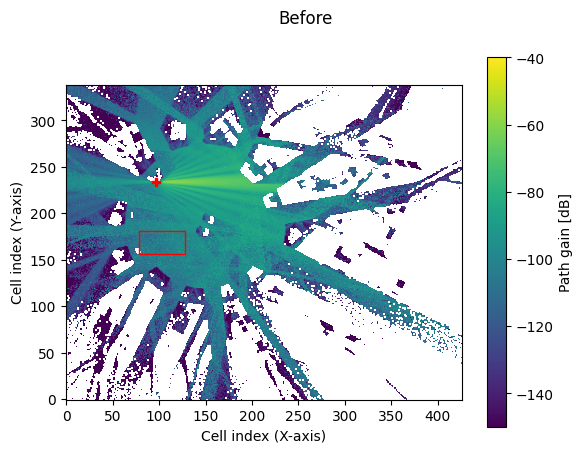

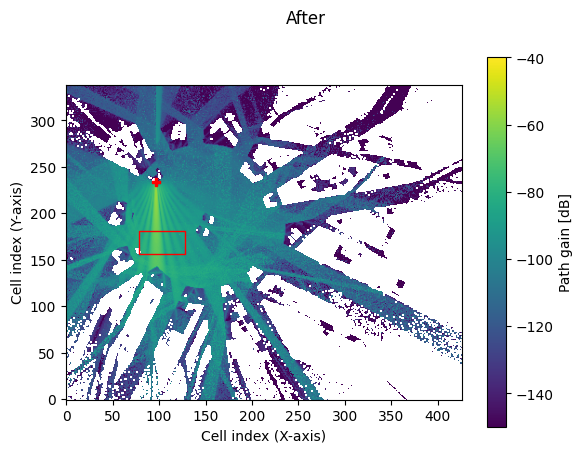

In [11]:
# Display the initial coverage map
fig = cm.show(vmin=-150, vmax=-40)
fig.suptitle("Before")
# Highlight the target area
visualize_target_area(fig.axes[0], cm_cell_size, target_center, target_size,)

# Display the optimized coverage map
fig = cm_new.show(vmin=-150, vmax=-40)
fig.suptitle("After")
# Highlight the target area
visualize_target_area(fig.axes[0], cm_cell_size, target_center, target_size)

We can also visualize the coverage maps as an overlay of the scene using the renderer.

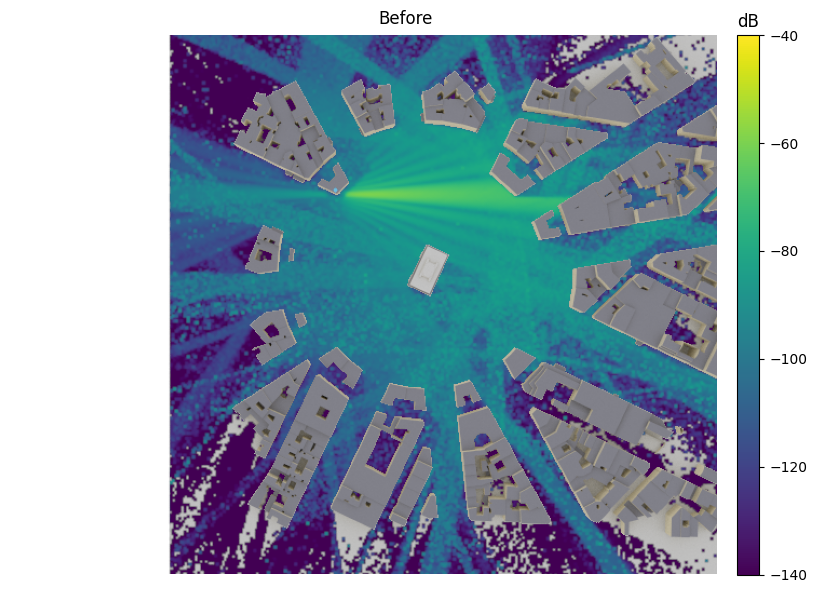

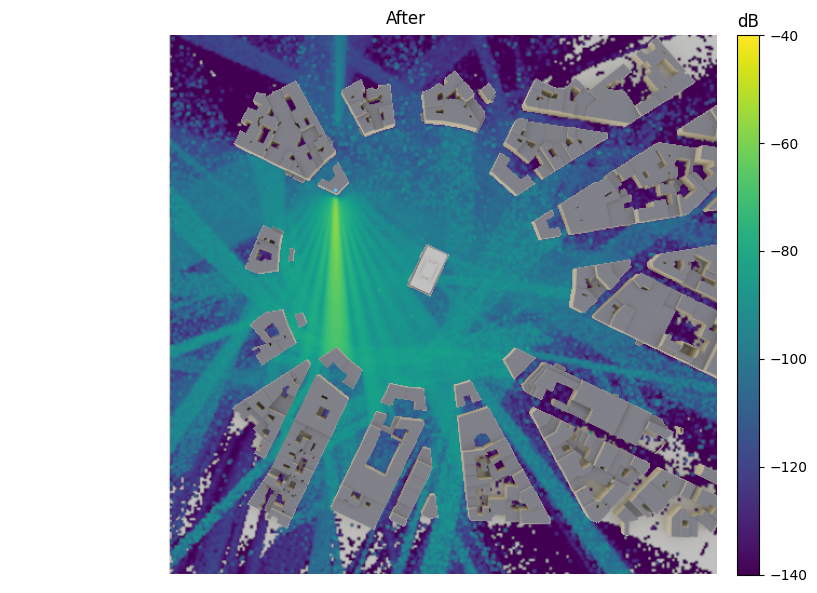

In [12]:
# Add a camera for viewing the scene from the sky
scene.add(Camera("top-view", position=(-200,0,1000), orientation=(0.5*np.pi, 0.5*np.pi, 0.0)))

# Rendering with the unoptimized orientation
fig = scene.render("top-view", coverage_map=cm, cm_vmin=-140, cm_vmax=-40)
fig.suptitle("Before")

# Rendering with the optimized orientation
fig = scene.render("top-view", coverage_map=cm_new, cm_vmin=-140, cm_vmax=-40)
fig.suptitle("After");

## Discussion

- Other loss functions could be used. For example, if multiple transmitters are considered, maximization of the signal-to-interference ratio could be used as objective function.

- Only the orientation is optimized in this notebook. However, other parameters could be learned as well, such as the geometry of the transmitter/receiver arrays as well as precoding vectors.

- In general, the optimization of a coverage map is a non-convex problem, especially when considering antenna arrays with complex radiation patterns. One could resort to other optimization methods such as Bayesian learning in this case.